In [1]:
import matplotlib.pyplot as plt
from plots.mpltoolkit import named_colors, fancy_legend, load_style_sheet
import numpy as np
import vice
import sys
sys.path.append("..")
from src.utils import get_velocity_profile
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
def mw_stellar_surface_density_profile(radius):
    sigma_0_thin = 1115e6
    sigma_0_thick = 300e6
    rs_thin = 2.5
    rs_thick = 2.0
    return sigma_0_thin * np.exp(-radius / rs_thin) + sigma_0_thick * np.exp(-radius / rs_thick)

In [3]:
output = vice.output("../outputs/test")

5.035e+10


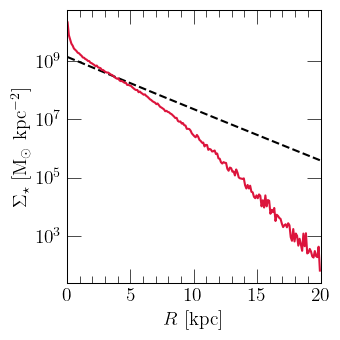

In [4]:
fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R$ [kpc]")
ax.set_ylabel(r"$\Sigma_\star$ [M$_\odot$ kpc$^{-2}$]")
ax.set_xlim([0, 20])
ax.set_yscale("log")

radii = [0.1 * (i + 0.5) for i in range(200)]
target = [mw_stellar_surface_density_profile(r) for r in radii]
ax.plot(radii, target, c = named_colors()["black"], linestyle = "--")

def plot_results(output, zone_width = 0.1, **kwargs):
    radii = []
    sigma = []
    mstar = 0
    for i in range(len(output.zones.keys())):
        radii.append(zone_width * (i + 0.5))
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        sigma.append(output.zones["zone%d" % (i)].history["mstar"][-1] / area)
        mstar += output.zones["zone%d" % (i)].history["mstar"][-1]
    print("%.3e" % (mstar))
    ax.plot(radii, sigma, **kwargs)

plot_results(output, c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

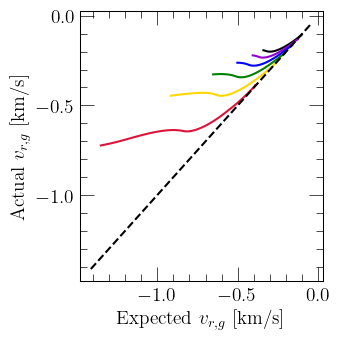

In [5]:
LOOKBACKS = [0, 2, 4, 6, 8, 10]
COLORS = ["black", "darkviolet", "blue", "green", "gold", "crimson"]

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Expected $v_{r,g}$ [km/s]")
ax.set_ylabel(r"Actual $v_{r,g}$ [km/s]")
# ax.set_xlim([-4, 0])
# ax.set_ylim(ax.get_xlim())

def expected_velocities(output, lookback, v_circ_ratio_in = 0.8, v_circ_ratio_out = 0, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    velocities = []
    for i in range(len(output.zones.keys())):
        radius = zone_width * (i + 0.5)
        zone = output.zones["zone%d" % (i)]
        v = zone.history["ofr"][idx] / zone.history["mgas"][idx] * 1.0e9 * (1 - v_circ_ratio_out)
        v -= zone.history["ifr"][idx] / zone.history["mgas"][idx] * 1.0e9 * (1 - v_circ_ratio_in)
        v *= radius
        velocities.append(v)
    return velocities

def plot_predictions(output, lookback, v_circ_ratio_in = 0.8, v_circ_ratio_out = 0, zone_width = 0.1, **kwargs):
    expected = expected_velocities(output, lookback,
        v_circ_ratio_in = v_circ_ratio_in,
        v_circ_ratio_out = v_circ_ratio_out,
        zone_width = zone_width)
    radii, actual = get_velocity_profile(output, lookback)
    ax.plot(expected[50:120], actual[50:120], **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"%g Gyr ago" % (LOOKBACKS[i])
    }
    plot_predictions(output, LOOKBACKS[i], **kwargs)

# ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), c = named_colors()["black"], linestyle = "--")
plt.tight_layout()
plt.show()